In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from fa2 import ForceAtlas2
import numpy as np
import re
import math
from collections import Counter
from scipy.spatial import distance
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import distance

In [2]:
data = pd.read_csv('data/all_vaccine_data.csv').query('lang == "en"')
data['user_id'] = data['user_id'].astype(int)
data['tweetid'] = data['tweetid'].astype(int)
data['retweeted_user_id'] = data['retweeted_user_id'].astype(int)
data

,Unnamed: 0,id,tweetid,guid,link,author,title,description,pubdate,source,...,user_id,profile_image_url,user_statuses_count,user_friends_count,user_followers_count,user_created_at,user_bio,user_location,user_verified,Unnamed: 29
0,0,1,1460093990007546112,https://twitter.com/AmbroiseLore/statuses/1460...,https://twitter.com/AmbroiseLore/statuses/1460...,AmbroiseLore,RT @eddiebouncer196: They will regret the day ...,They will regret the day that they fired the n...,2021-11-14 22:55:09,Twitter for iPhone,...,1443801237317558272,https://pbs.twimg.com/profile_images/144500771...,313,157,25,2021-10-01 00:53:56,| Freedom for The People. Stoic. Vi Veri Veriv...,Australia,NaN,NaN
1,2,3,1460093986748702720,https://twitter.com/NiburiHasReturn/statuses/1...,https://twitter.com/NiburiHasReturn/statuses/1...,NiburiHasReturn,RT @thebradfordfile: The mandate isn\'t about ...,The mandate isn\'t about a vaccine. It\'s abo...,2021-11-14 22:55:08,Twitter for iPhone,...,314868247,https://pbs.twimg.com/profile_images/895449072...,61730,253,921,2011-06-10 19:11:54,God is a black woman.,Niburi,NaN,NaN
2,4,5,1460093985146429440,https://twitter.com/NewsKlw/statuses/146009398...,https://twitter.com/NewsKlw/statuses/146009398...,NewsKlw,RT @BreitbartNews: Anthony Fauci declared this...,Anthony Fauci declared this week that a vaccin...,2021-11-14 22:55:07,Twitter Web App,...,1344707269393571840,https://pbs.twimg.com/profile_images/134470812...,18035,301,736,2020-12-31 13:09:46,KLW World News covering news from around the w...,Global,NaN,NaN
3,6,7,1460093983988854784,https://twitter.com/m2conte/statuses/146009398...,https://twitter.com/m2conte/statuses/146009398...,m2conte,RT @ChuckCallesto: BREAKING REPORT: Taiwan Sus...,BREAKING REPORT: Taiwan Suspends Second Round ...,2021-11-14 22:55:07,Twitter for iPhone,...,835565706284527616,https://pbs.twimg.com/profile_images/835607817...,595,275,90,2017-02-25 14:02:43,Professional Mechanic. God Fearing Family Chri...,"Clinton, OH",NaN,NaN
4,7,8,1460093983271440384,https://twitter.com/TippyTaff/statuses/1460093...,https://twitter.com/TippyTaff/statuses/1460093...,TippyTaff,"RT @ReportsDaNews: JUST IN: Texas doctor, Mar...","JUST IN: Texas doctor, Mary Bowden, who defen...",2021-11-14 22:55:07,Twitter for Android,...,2919743208,https://pbs.twimg.com/profile_images/540890881...,20872,869,290,2014-12-05 10:26:58,NaN,"Chandler, AZ",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039057,99994,99995,1471421231199051776,https://twitter.com/Bisswissey1/statuses/14714...,https://twitter.com/Bisswissey1/statuses/14714...,Bisswissey1,RT @69Positionss: You Go Take The Vaccine ð...,You Go Take The Vaccine ð Or Your Body Canâ...,2021-12-16 05:05:33,Twitter for Android,...,1094924033534115840,https://pbs.twimg.com/profile_images/141439024...,57450,5309,11205,2019-02-11 06:40:07,Binance Affiliate Member DM for your Binance a...,Binancian,NaN,NaN
2039058,99995,99996,1471421230163140608,https://twitter.com/Ettel_wen/statuses/1471421...,https://twitter.com/Ettel_wen/statuses/1471421...,Ettel_wen,"#VaccineMandate is unethical, immoral, counter...","#VaccineMandate is unethical, immoral, counter...",2021-12-16 05:05:33,Twitter for Android,...,1226432762103635968,https://pbs.twimg.com/profile_images/122643342...,24626,1796,334,2020-02-09 04:09:04,NaN,NaN,NaN,NaN
2039059,99996,99997,1471421230112817152,https://twitter.com/MentalChrysalis/statuses/1...,https://twitter.com/MentalChrysalis/statuses/1...,MentalChrysalis,RT @Cooper4SAE: This is disturbing. Hidden in ...,This is disturbing. Hidden in the Fiscal and E...,2021-12-16 05:05:33,Twitter Web App,...,825027635163959296,https://pbs.twimg.com/profile_images/110700136...,28699,2569,2099,2017-01-27 12:08:11,I encourage you to examine what you believe in...,Canada,NaN,NaN
2039060,99997,99998,1471421229349355520,https://twitter.com/aev1609/statuses/147142122...,https://twitter.com/aev1609/statuses/147142122...,aev1609,RT @RichardBurgon:

In [15]:
hashtag_counter = Counter()

for i in tqdm(data.index):
    hashtags = re.findall('#(\w+)', data.loc[i, 'description'])
    for ht in hashtags:
        ht = ht.lower().replace('_', '')
        if ht not in hashtag_counter:
            hashtag_counter[ht] = 1
        else:
            hashtag_counter[ht] += 1

  0%|          | 0/2039062 [00:00<?, ?it/s]

In [16]:
n = 3500
unique_hashtags = set([
    i[0] for i in hashtag_counter.most_common(n)
])
counter = 0
hashtag_to_id = {ht: i for i, ht in enumerate(unique_hashtags)}
id_to_hashtag = {i: ht for i, ht in enumerate(unique_hashtags)}

hashtags_co_occurrence = np.zeros((len(unique_hashtags), len(unique_hashtags)), dtype=int)

for i in tqdm(data.index):
    hashtags = re.findall('#(\w+)', data.loc[i, 'description'])
    hashtags = [ht for ht in hashtags if ht in unique_hashtags]
    if len(hashtags) > 1:
        for ht_i in hashtags:
            for ht_j in hashtags:
                if ht_i != ht_j:
                    hashtags_co_occurrence[hashtag_to_id[ht_i], hashtag_to_id[ht_j]] += 1

for i in range(len(hashtags_co_occurrence)):
    for j in range(len(hashtags_co_occurrence)):
        if j >= i:
            hashtags_co_occurrence[j, i] = 0

columns = [id_to_hashtag[i] for i in range(n)]
hashtags_co_occurrence = pd.DataFrame(hashtags_co_occurrence,
                                      columns=columns,
                                      index=columns)

a = hashtags_co_occurrence.stack()
a = a[a >= 1].rename_axis(('source', 'target')).reset_index(name='weight')

  0%|          | 0/2039062 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:58<00:00, 34.33it/s]


BarnesHut Approximation  took  16.47  seconds
Repulsion forces  took  38.83  seconds
Gravitational forces  took  0.20  seconds
Attraction forces  took  0.62  seconds
AdjustSpeedAndApplyForces step  took  0.70  seconds


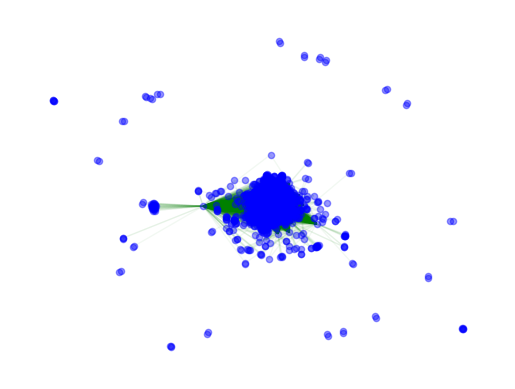

In [10]:
G = nx.from_pandas_edgelist(a,  edge_attr=True)

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=20, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

In [12]:
distances = np.array([1e10] * len(unique_hashtags))
hashtag = 'antivax'

for ht in positions:
    distances[hashtag_to_id[ht]] = distance.euclidean(
        positions[hashtag], positions[ht]
    )
for i in np.argsort(distances)[1:100]:
    print(id_to_hashtag[i])

respect
covidpass
followthemoney
nuremberg
sideeffects
unvaxxed
teachers
pfizerleaks
pureblood
antivaxxer
covidjab
nursing
coercion
parliament
johnsonandjohnson
tripswaiver
diedsuddenly
athletes
lies
pfizergate
experimental
evil
allfactsmatter
cardiac
pfizergates
heartattacks
dementia
vaccinemandates
apartheid
jabs
peoplesvaccine
illegal
pandemicofthevaccinated
police
ceo
segregation
heart
fearmongering
testing
vaxxed
phizer
billgates
history
modiji
criminal
cardiacarrest
corruption
travelban
globalreset
england
bigpharmacartel
choice
bloodclots
depopulation
coverup
newvariant
treatment
covidmandates
worldnews
inflammation
suddendeath
longcovid
mandate
humanrights
msm
boostershots
tyranny
vaccinefree
transhumanism
rondesantis
vaccineâ
longhaulers
arrestbillgates
discrimination
boosters
flatearth
plandemic
football
scamdemic
heartattack
healthcareworkers
wakeup
fact
cms
unvaccinated
event201
access2meds
fascism
germany
bigpharma
crime
government
nazi
court
legal
nyc
wtf
united
barrie


In [3]:
retweet_data = data.query('tweet_type == "retweet"')
retweet_data

,Unnamed: 0,id,tweetid,guid,link,author,title,description,pubdate,source,...,user_id,profile_image_url,user_statuses_count,user_friends_count,user_followers_count,user_created_at,user_bio,user_location,user_verified,Unnamed: 29
0,0,1,1460093990007546112,https://twitter.com/AmbroiseLore/statuses/1460...,https://twitter.com/AmbroiseLore/statuses/1460...,AmbroiseLore,RT @eddiebouncer196: They will regret the day ...,They will regret the day that they fired the n...,2021-11-14 22:55:09,Twitter for iPhone,...,1443801237317558272,https://pbs.twimg.com/profile_images/144500771...,313,157,25,2021-10-01 00:53:56,| Freedom for The People. Stoic. Vi Veri Veriv...,Australia,NaN,NaN
1,2,3,1460093986748702720,https://twitter.com/NiburiHasReturn/statuses/1...,https://twitter.com/NiburiHasReturn/statuses/1...,NiburiHasReturn,RT @thebradfordfile: The mandate isn\'t about ...,The mandate isn\'t about a vaccine. It\'s abo...,2021-11-14 22:55:08,Twitter for iPhone,...,314868247,https://pbs.twimg.com/profile_images/895449072...,61730,253,921,2011-06-10 19:11:54,God is a black woman.,Niburi,NaN,NaN
2,4,5,1460093985146429440,https://twitter.com/NewsKlw/statuses/146009398...,https://twitter.com/NewsKlw/statuses/146009398...,NewsKlw,RT @BreitbartNews: Anthony Fauci declared this...,Anthony Fauci declared this week that a vaccin...,2021-11-14 22:55:07,Twitter Web App,...,1344707269393571840,https://pbs.twimg.com/profile_images/134470812...,18035,301,736,2020-12-31 13:09:46,KLW World News covering news from around the w...,Global,NaN,NaN
3,6,7,1460093983988854784,https://twitter.com/m2conte/statuses/146009398...,https://twitter.com/m2conte/statuses/146009398...,m2conte,RT @ChuckCallesto: BREAKING REPORT: Taiwan Sus...,BREAKING REPORT: Taiwan Suspends Second Round ...,2021-11-14 22:55:07,Twitter for iPhone,...,835565706284527616,https://pbs.twimg.com/profile_images/835607817...,595,275,90,2017-02-25 14:02:43,Professional Mechanic. God Fearing Family Chri...,"Clinton, OH",NaN,NaN
4,7,8,1460093983271440384,https://twitter.com/TippyTaff/statuses/1460093...,https://twitter.com/TippyTaff/statuses/1460093...,TippyTaff,"RT @ReportsDaNews: JUST IN: Texas doctor, Mar...","JUST IN: Texas doctor, Mary Bowden, who defen...",2021-11-14 22:55:07,Twitter for Android,...,2919743208,https://pbs.twimg.com/profile_images/540890881...,20872,869,290,2014-12-05 10:26:58,NaN,"Chandler, AZ",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2039056,99992,99993,1471421231622606848,https://twitter.com/becwin58_winter/statuses/1...,https://twitter.com/becwin58_winter/statuses/1...,becwin58_winter,RT @MythinformedMKE: Dr. Peter McCullough expl...,"Dr. Peter McCullough explains to Joe Rogan, th...",2021-12-16 05:05:33,Twitter Web App,...,2199694123,https://pbs.twimg.com/profile_images/125042941...,22360,2353,708,2013-11-17 10:20:32,ððð,"California, USA",NaN,NaN
2039057,99994,99995,1471421231199051776,https://twitter.com/Bisswissey1/statuses/14714...,https://twitter.com/Bisswissey1/statuses/14714...,Bisswissey1,RT @69Positionss: You Go Take The Vaccine ð...,You Go Take The Vaccine ð Or Your Body Canâ...,2021-12-16 05:05:33,Twitter for Android,...,1094924033534115840,https://pbs.twimg.com/profile_images/141439024...,57450,5309,11205,2019-02-11 06:40:07,Binance Affiliate Member DM for your Binance a...,Binancian,NaN,NaN
2039059,99996,99997,1471421230112817152,https://twitter.com/MentalChrysalis/statuses/1...,https://twitter.com/MentalChrysalis/statuses/1...,MentalChrysalis,RT @Cooper4SAE: This is disturbing. Hidden in ...,This is disturbing. Hidden in the Fiscal and E...,2021-12-16 05:05:33,Twitter Web App,...,825027635163959296,https://pbs.twimg.com/profile_images/110700136...,28699,2569,2099,2017-01-27 12:08:11,I encourage you to examine what you believe in...,Canada,NaN,NaN
2039060,99997,99998,1471421229349355520,https://twitter.com/aev1609/statuses/147142122...,https://twitter.com/aev1609/statuses/147142122...,aev1609,RT @

In [5]:
import pickle

# with open('retweet_graph.pickle', 'wb') as f:
#     pickle.dump(retweet_graph, f)
#
# with open('positions_retweet_graph.pickle', 'wb') as f:
#     pickle.dump(positions_retweet_graph, f)

with open('retweet_graph.pickle', 'rb') as f:
    retweet_graph = pickle.load(f)

with open('positions_retweet_graph.pickle', 'rb') as f:
    positions_retweet_graph = pickle.load(f)

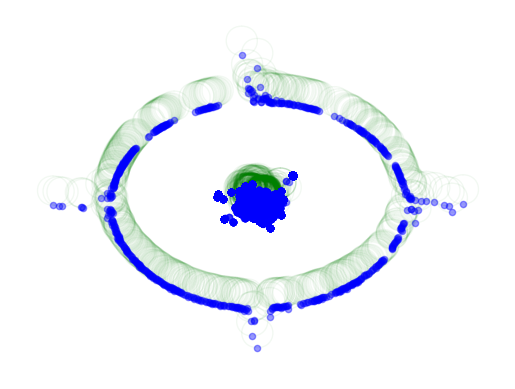

In [6]:
nx.draw_networkx_nodes(retweet_graph, positions_retweet_graph, node_size=20, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(retweet_graph, positions_retweet_graph, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

In [7]:
def visualize_clusters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

In [22]:
from sklearn.cluster import DBSCAN
dotes = np.array([[i[0], i[1]] for i in positions_retweet_graph.values()])
clustering = DBSCAN(eps=5500, min_samples=10).fit(dotes)
clusters_labels = clustering.labels_

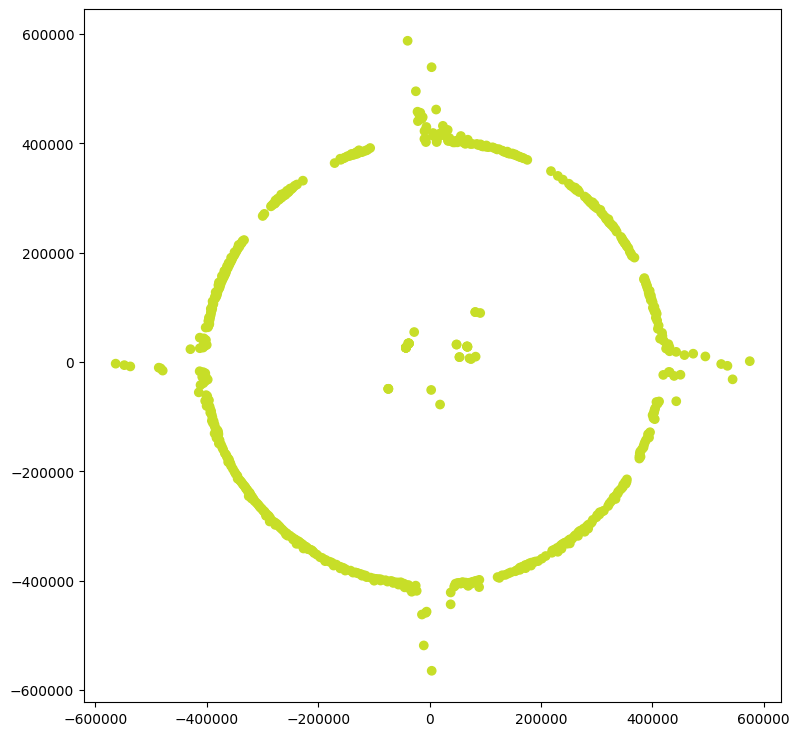

In [23]:
cluster_dotes_1 = np.array([dot for i, dot in enumerate(dotes) if clusters_labels[i] == -1])

visualize_clusters(
    cluster_dotes_1,
    [0] * len(cluster_dotes_1)
)

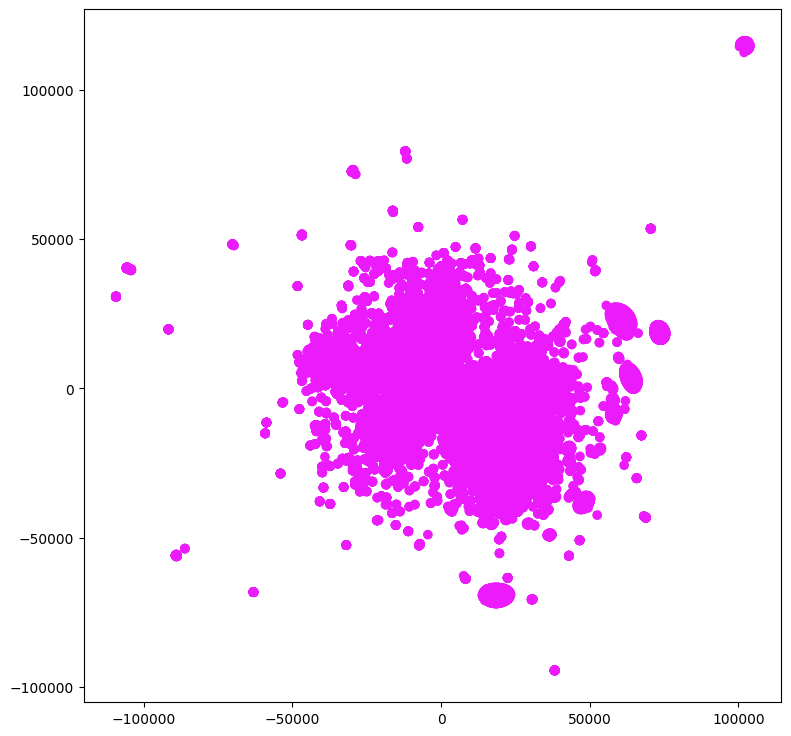

In [24]:
cluster_dotes_2 = np.array([dot for i, dot in enumerate(dotes) if clusters_labels[i] != -1])

visualize_clusters(
    cluster_dotes_2,
    [0] * len(cluster_dotes_2)
)

In [41]:
cluster_1 = set([dot for i, dot in enumerate(positions_retweet_graph) if clusters_labels[i] == -1])

In [46]:
retweets = {}
for i in tqdm(retweet_data.index):
    user_id = retweet_data.loc[i, 'user_id']
    retweeted_user_id = retweet_data.loc[i, 'retweeted_user_id']
    if user_id not in cluster_1 and retweeted_user_id not in cluster_1:
        if user_id in retweets:
            if retweeted_user_id in retweets[user_id]:
                retweets[user_id][retweeted_user_id]['weight'] += 1
            else:
                retweets[user_id][retweeted_user_id] = {'weight': 1}
        else:
            retweets[user_id] = {}
            retweets[user_id][retweeted_user_id] = {'weight': 1}

  0%|          | 0/1387826 [00:00<?, ?it/s]

In [47]:
strong_retweets = []

for key in tqdm(retweets):
    for node in retweets[key]:
        weight = retweets[key][node]['weight']
        if weight >= 4:
            strong_retweets.append([key, node, weight])

strong_retweets = pd.DataFrame(strong_retweets, columns=['source', 'target', 'weight'])
retweet_graph = nx.from_pandas_edgelist(strong_retweets, edge_attr=True)

strong_retweets

  0%|          | 0/551035 [00:00<?, ?it/s]

,source,target,weight
0,3162911248,16813044,5
1,1259128950380466176,39844876,4
2,533225272,593289567,5
3,17840670,321954654,4
4,17840670,1356282424313999360,4
...,...,...,...
7989,1467928044807589888,3034814919,4
7990,1348254935746564096,1385046120682950912,6
7991,958324324741521408,1470253421861031936,4
7992,18493926,3034814919,5


100%|██████████| 2000/2000 [04:45<00:00,  6.99it/s]


BarnesHut Approximation  took  114.78  seconds
Repulsion forces  took  162.52  seconds
Gravitational forces  took  0.80  seconds
Attraction forces  took  0.37  seconds
AdjustSpeedAndApplyForces step  took  2.92  seconds


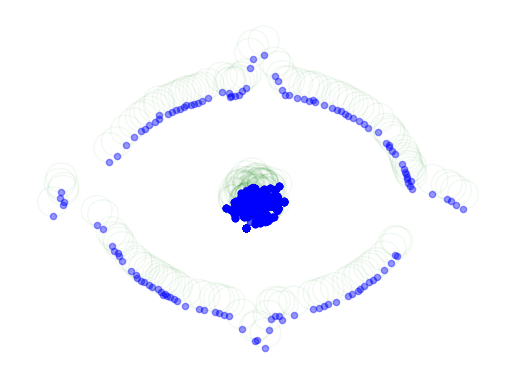

In [48]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=True)

positions_retweet_graph = forceatlas2.forceatlas2_networkx_layout(retweet_graph, pos=None, iterations=2000)
nx.draw_networkx_nodes(retweet_graph, positions_retweet_graph, node_size=20, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(retweet_graph, positions_retweet_graph, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()